# Negative Fake Companion Technique 
## Using GPU

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%load_ext autoreload
%autoreload 2

2023-05-19 17:33:50.712963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 17:33:51.503883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/users/cdonoso/miniconda3/envs/tf2/lib/:/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-05-19 17:33:51.503955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH:

### Loading data

In [17]:
root = './data/fake//'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 
cube = cube[None,...]
psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (80, 1023, 1023)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

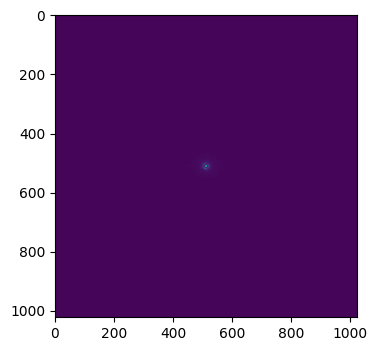

In [18]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [19]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

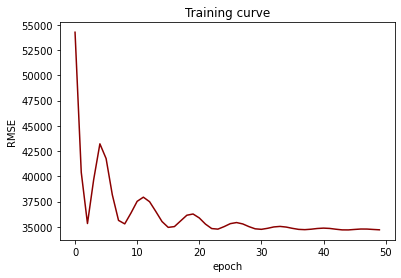

In [20]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [21]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

TensorShape([2, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [22]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

In [23]:
cube[0, 0].shape, normalized_psf[0].shape

((1023, 1023), TensorShape([64, 64]))

### PCA: Extracting most variable pixels along the time axis from the cube of frames

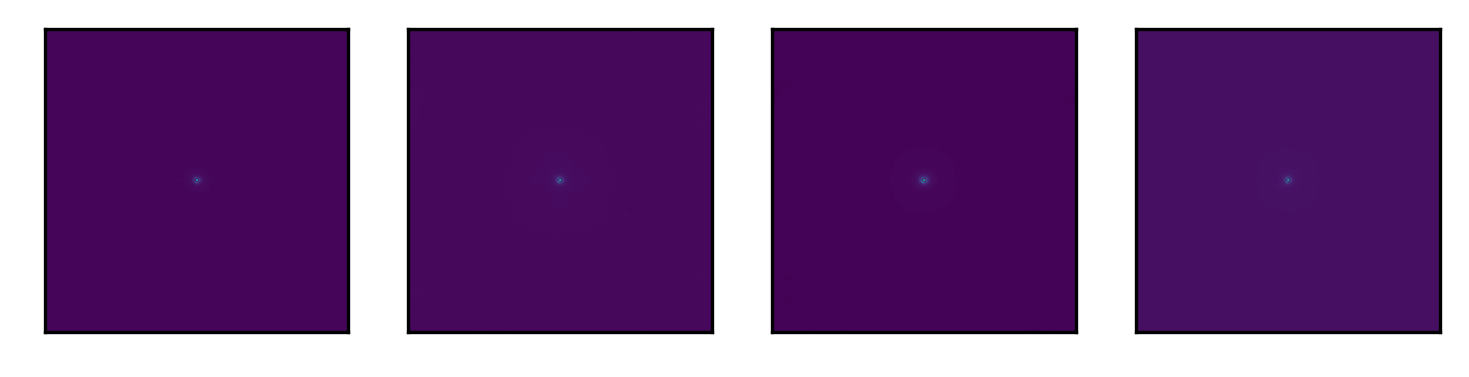

In [24]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [25]:
cube[0].shape

(80, 1023, 1023)

In [26]:
%%time
adi_image, res_cube = tfnegfc.apply_adi(cube[0], 
                                        rot_ang, 
                                        out_size=cube[0].shape, 
                                        ncomp=2, 
                                        derotate='tf', return_cube=True)

CPU times: user 790 ms, sys: 857 ms, total: 1.65 s
Wall time: 1.65 s


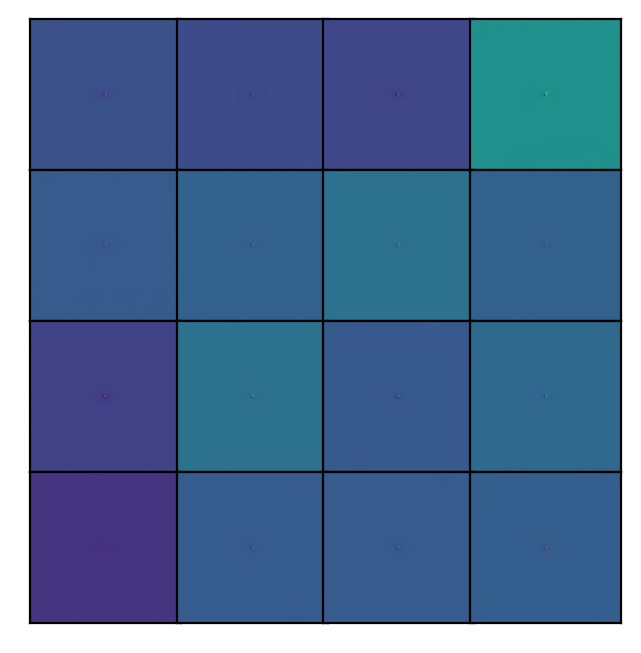

In [27]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=200,
                        gridspec_kw={'hspace': 0., 'wspace': -0.7},)
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(res_cube[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])

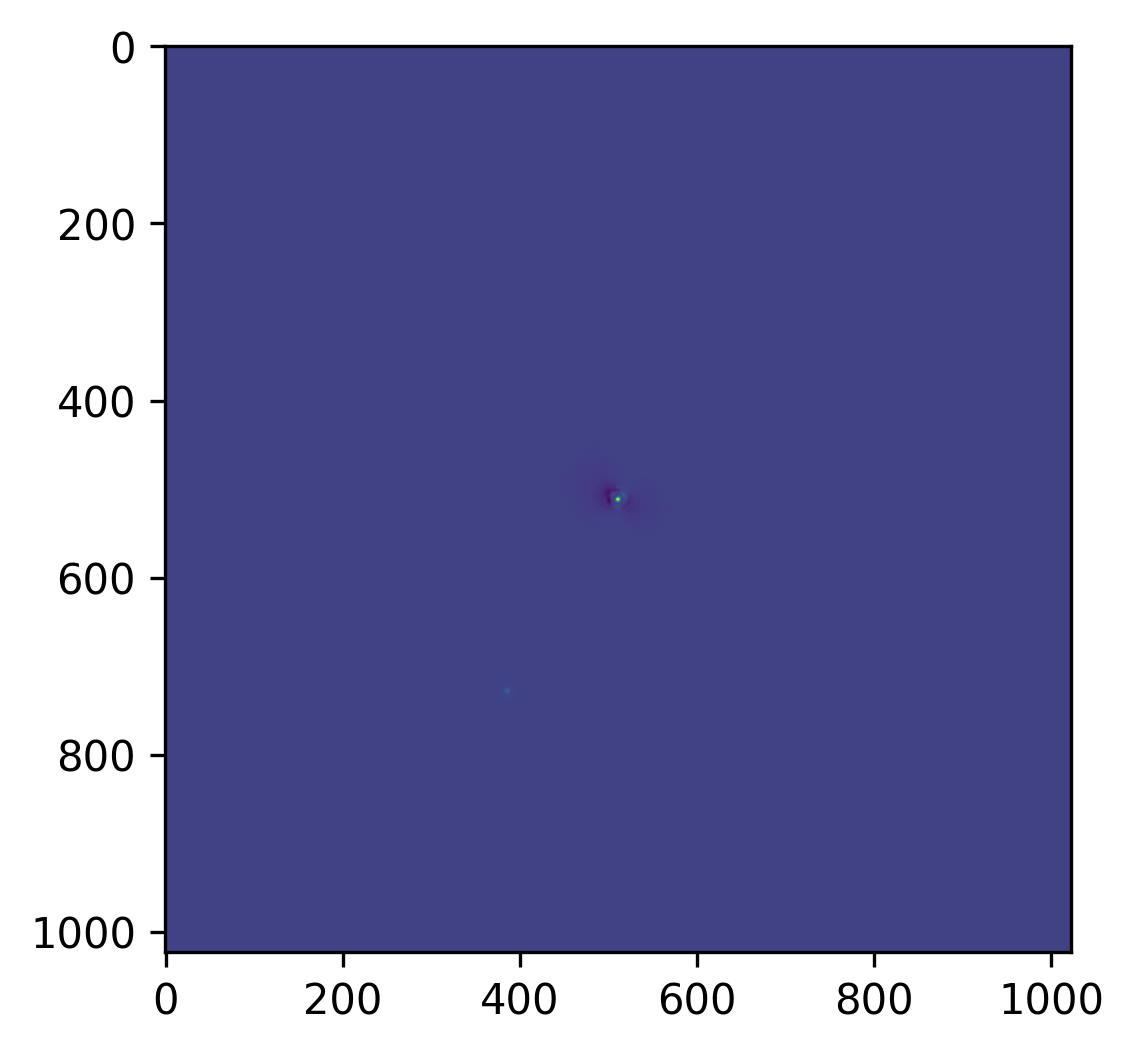

In [28]:
plt.figure(dpi=300)
plt.imshow(adi_image)

In [17]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 8.31 s, sys: 66.4 ms, total: 8.37 s
Wall time: 8.25 s


In [18]:
table

,x,y,flux,fwhm_mean,snr
0,385.651886,727.766296,9.68365,4.787644,94.004267


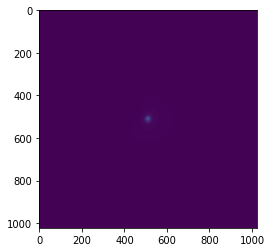

In [19]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [20]:
from tensorflow.keras.optimizers import Adam 
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def wrapper(fn, fwhm, std=True):
    def inner(*args):
        out = fn(*args, fwhm=fwhm, std=std)
        return out
    return inner

In [29]:
nfwhm = 1
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean']*nfwhm, std=False)

dataset, recovery = get_dataset(cube, normalized_psf, rot_ang, normalize=0)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    
# model.summary()

In [33]:
# x_ = table.iloc[0]['x']
# y_ = table.iloc[0]['y']
# fwhm_ = table.iloc[0]['fwhm_mean']

# obj_reg = tfnegfc.get_objective_region(adi_image, x_, y_, rot_ang, fwhm_*nfwhm)
# plt.figure()
# plt.imshow(obj_reg[0])
# plt.ylim(y_-50, y_+50)
# plt.xlim(x_-50, x_+50)

In [31]:
%%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=20,
)
model.compile(loss_fn=custom_loss_w, optimizer=Adam(5))

hist = model.fit(dataset, epochs=10000, verbose=1, callbacks=[es])

Epoch 1/10000
1/1 [==============================] - 5s 5s/step - loss: 29.7590
Epoch 2/10000
1/1 [==============================] - 1s 1s/step - loss: 29.6077
Epoch 3/10000
1/1 [==============================] - 1s 1s/step - loss: 29.4467
Epoch 4/10000
1/1 [==============================] - 1s 1s/step - loss: 29.2911
Epoch 5/10000
1/1 [==============================] - 1s 1s/step - loss: 29.1382
Epoch 6/10000
1/1 [==============================] - 1s 1s/step - loss: 28.9886
Epoch 7/10000
1/1 [==============================] - 1s 1s/step - loss: 28.8319
Epoch 8/10000
1/1 [==============================] - 1s 1s/step - loss: 28.6834
Epoch 9/10000
1/1 [==============================] - 1s 1s/step - loss: 28.5559
Epoch 10/10000
1/1 [==============================] - 1s 1s/step - loss: 28.4516
Epoch 11/10000
1/1 [==============================] - 1s 1s/step - loss: 28.3171
Epoch 12/10000
1/1 [==============================] - 1s 1s/step - loss: 28.1455
Epoch 13/10000
1/1 [=================

1/1 [==============================] - 1s 1s/step - loss: 11.8219
Epoch 203/10000
1/1 [==============================] - 1s 1s/step - loss: 11.7961
Epoch 204/10000
1/1 [==============================] - 1s 1s/step - loss: 11.7700
Epoch 205/10000
1/1 [==============================] - 1s 1s/step - loss: 11.7442
Epoch 206/10000
1/1 [==============================] - 1s 1s/step - loss: 11.7181
Epoch 207/10000
1/1 [==============================] - 1s 1s/step - loss: 11.6919
Epoch 208/10000
1/1 [==============================] - 1s 1s/step - loss: 11.6675
Epoch 209/10000
1/1 [==============================] - 1s 1s/step - loss: 11.6394
Epoch 210/10000
1/1 [==============================] - 1s 1s/step - loss: 11.6112
Epoch 211/10000
1/1 [==============================] - 1s 1s/step - loss: 11.5803
Epoch 212/10000
1/1 [==============================] - 1s 1s/step - loss: 11.5488
Epoch 213/10000
1/1 [==============================] - 1s 1s/step - loss: 11.5172
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 5.0230
Epoch 404/10000
1/1 [==============================] - 1s 1s/step - loss: 5.0084
Epoch 405/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9941
Epoch 406/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9796
Epoch 407/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9650
Epoch 408/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9507
Epoch 409/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9363
Epoch 410/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9220
Epoch 411/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9073
Epoch 412/10000
1/1 [==============================] - 1s 1s/step - loss: 4.8929
Epoch 413/10000
1/1 [==============================] - 1s 1s/step - loss: 4.8788
Epoch 414/10000
1/1 [==============================] - 1s 1s/step - loss: 4.8649
Epoch 415/10000
1/1 [=======================

1/1 [==============================] - 1s 1s/step - loss: 3.2559
Epoch 606/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2484
Epoch 607/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2407
Epoch 608/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2331
Epoch 609/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2254
Epoch 610/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2177
Epoch 611/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2100
Epoch 612/10000
1/1 [==============================] - 1s 1s/step - loss: 3.2024
Epoch 613/10000
1/1 [==============================] - 1s 1s/step - loss: 3.1953
Epoch 614/10000
1/1 [==============================] - 1s 1s/step - loss: 3.1884
Epoch 615/10000
1/1 [==============================] - 1s 1s/step - loss: 3.1815
Epoch 616/10000
1/1 [==============================] - 1s 1s/step - loss: 3.1746
Epoch 617/10000
1/1 [=======================

1/1 [==============================] - 1s 1s/step - loss: 1.8130
Epoch 808/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8086
Epoch 809/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8042
Epoch 810/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7999
Epoch 811/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7957
Epoch 812/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7916
Epoch 813/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7875
Epoch 814/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7835
Epoch 815/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7795
Epoch 816/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7756
Epoch 817/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7715
Epoch 818/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7674
Epoch 819/10000
1/1 [=======================

1/1 [==============================] - 1s 1s/step - loss: 0.9333
Epoch 1010/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9295
Epoch 1011/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9257
Epoch 1012/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9220
Epoch 1013/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9184
Epoch 1014/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9148
Epoch 1015/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9114
Epoch 1016/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9078
Epoch 1017/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9044
Epoch 1018/10000
1/1 [==============================] - 1s 1s/step - loss: 0.9009
Epoch 1019/10000
1/1 [==============================] - 1s 1s/step - loss: 0.8975
Epoch 1020/10000
1/1 [==============================] - 1s 1s/step - loss: 0.8940
Epoch 1021/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.6568
Epoch 1110/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6548
Epoch 1111/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6526
Epoch 1112/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6505
Epoch 1113/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6484
Epoch 1114/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6463
Epoch 1115/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6443
Epoch 1116/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6424
Epoch 1117/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6405
Epoch 1118/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6386
Epoch 1119/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6368
Epoch 1120/10000
1/1 [==============================] - 1s 1s/step - loss: 0.6350
Epoch 1121/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.4875
Epoch 1210/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4860
Epoch 1211/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4845
Epoch 1212/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4830
Epoch 1213/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4816
Epoch 1214/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4801
Epoch 1215/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4787
Epoch 1216/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4773
Epoch 1217/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4760
Epoch 1218/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4746
Epoch 1219/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4732
Epoch 1220/10000
1/1 [==============================] - 1s 1s/step - loss: 0.4718
Epoch 1221/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.3668
Epoch 1310/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3658
Epoch 1311/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3648
Epoch 1312/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3638
Epoch 1313/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3628
Epoch 1314/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3618
Epoch 1315/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3607
Epoch 1316/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3597
Epoch 1317/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3587
Epoch 1318/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3577
Epoch 1319/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3567
Epoch 1320/10000
1/1 [==============================] - 1s 1s/step - loss: 0.3557
Epoch 1321/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.2641
Epoch 1410/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2630
Epoch 1411/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2618
Epoch 1412/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2606
Epoch 1413/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2594
Epoch 1414/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2582
Epoch 1415/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2570
Epoch 1416/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2558
Epoch 1417/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2546
Epoch 1418/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2534
Epoch 1419/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2522
Epoch 1420/10000
1/1 [==============================] - 1s 1s/step - loss: 0.2511
Epoch 1421/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.1491
Epoch 1510/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1481
Epoch 1511/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1472
Epoch 1512/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1463
Epoch 1513/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1453
Epoch 1514/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1444
Epoch 1515/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1435
Epoch 1516/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1426
Epoch 1517/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1417
Epoch 1518/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1408
Epoch 1519/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1399
Epoch 1520/10000
1/1 [==============================] - 1s 1s/step - loss: 0.1390
Epoch 1521/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0895
Epoch 1610/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0892
Epoch 1611/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0888
Epoch 1612/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0884
Epoch 1613/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0880
Epoch 1614/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0877
Epoch 1615/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0873
Epoch 1616/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0870
Epoch 1617/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0866
Epoch 1618/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0862
Epoch 1619/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0859
Epoch 1620/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0855
Epoch 1621/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0622
Epoch 1710/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0620
Epoch 1711/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0618
Epoch 1712/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0617
Epoch 1713/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0615
Epoch 1714/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0613
Epoch 1715/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0611
Epoch 1716/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0609
Epoch 1717/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0607
Epoch 1718/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0605
Epoch 1719/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0603
Epoch 1720/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0601
Epoch 1721/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0436
Epoch 1810/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0434
Epoch 1811/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0433
Epoch 1812/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0431
Epoch 1813/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0430
Epoch 1814/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0428
Epoch 1815/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0427
Epoch 1816/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0425
Epoch 1817/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0424
Epoch 1818/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0422
Epoch 1819/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0421
Epoch 1820/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0419
Epoch 1821/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0309
Epoch 1910/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0308
Epoch 1911/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0307
Epoch 1912/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0306
Epoch 1913/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0305
Epoch 1914/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0305
Epoch 1915/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0304
Epoch 1916/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0303
Epoch 1917/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0302
Epoch 1918/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0301
Epoch 1919/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0300
Epoch 1920/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0299
Epoch 1921/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0219
Epoch 2010/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0219
Epoch 2011/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0218
Epoch 2012/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0217
Epoch 2013/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0216
Epoch 2014/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0215
Epoch 2015/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0214
Epoch 2016/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0213
Epoch 2017/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0212
Epoch 2018/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0211
Epoch 2019/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0211
Epoch 2020/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0210
Epoch 2021/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0144
Epoch 2110/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0143
Epoch 2111/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0142
Epoch 2112/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0142
Epoch 2113/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0141
Epoch 2114/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0141
Epoch 2115/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0140
Epoch 2116/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0139
Epoch 2117/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0139
Epoch 2118/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0138
Epoch 2119/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0138
Epoch 2120/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0137
Epoch 2121/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0082
Epoch 2210/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0082
Epoch 2211/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0081
Epoch 2212/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0080
Epoch 2213/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0080
Epoch 2214/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0079
Epoch 2215/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0079
Epoch 2216/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0078
Epoch 2217/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0078
Epoch 2218/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0077
Epoch 2219/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0077
Epoch 2220/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0076
Epoch 2221/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0043
Epoch 2310/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2311/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2312/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2313/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2314/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0042
Epoch 2315/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0041
Epoch 2316/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0041
Epoch 2317/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0041
Epoch 2318/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0041
Epoch 2319/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0040
Epoch 2320/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0040
Epoch 2321/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2410/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2411/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2412/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2413/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2414/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2415/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0024
Epoch 2416/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 2417/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 2418/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 2419/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 2420/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0023
Epoch 2421/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 0.0013
Epoch 2510/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0013
Epoch 2511/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0013
Epoch 2512/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0013
Epoch 2513/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2514/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2515/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2516/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2517/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2518/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2519/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2520/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0012
Epoch 2521/10000
1/1 [===========

1/1 [==============================] - 1s 1s/step - loss: 6.6026e-04
Epoch 2607/10000
1/1 [==============================] - 1s 1s/step - loss: 6.5651e-04
Epoch 2608/10000
1/1 [==============================] - 1s 1s/step - loss: 6.5215e-04
Epoch 2609/10000
1/1 [==============================] - 1s 1s/step - loss: 6.4758e-04
Epoch 2610/10000
1/1 [==============================] - 1s 1s/step - loss: 6.4429e-04
Epoch 2611/10000
1/1 [==============================] - 1s 1s/step - loss: 6.4092e-04
Epoch 2612/10000
1/1 [==============================] - 1s 1s/step - loss: 6.3721e-04
Epoch 2613/10000
1/1 [==============================] - 1s 1s/step - loss: 6.3140e-04
Epoch 2614/10000
1/1 [==============================] - 1s 1s/step - loss: 6.2899e-04
Epoch 2615/10000
1/1 [==============================] - 1s 1s/step - loss: 6.2433e-04
Epoch 2616/10000
1/1 [==============================] - 1s 1s/step - loss: 6.2020e-04
Epoch 2617/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 1.8705e-04
Epoch 2797/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8544e-04
Epoch 2798/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8402e-04
Epoch 2799/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8356e-04
Epoch 2800/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8198e-04
Epoch 2801/10000
1/1 [==============================] - 1s 1s/step - loss: 1.8024e-04
Epoch 2802/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7902e-04
Epoch 2803/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7823e-04
Epoch 2804/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7652e-04
Epoch 2805/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7571e-04
Epoch 2806/10000
1/1 [==============================] - 1s 1s/step - loss: 1.7411e-04
Epoch 2807/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 4.9283e-05
Epoch 2987/10000
1/1 [==============================] - 1s 1s/step - loss: 4.9048e-05
Epoch 2988/10000
1/1 [==============================] - 1s 1s/step - loss: 4.8401e-05
Epoch 2989/10000
1/1 [==============================] - 1s 1s/step - loss: 4.8119e-05
Epoch 2990/10000
1/1 [==============================] - 1s 1s/step - loss: 4.7767e-05
Epoch 2991/10000
1/1 [==============================] - 1s 1s/step - loss: 4.7619e-05
Epoch 2992/10000
1/1 [==============================] - 1s 1s/step - loss: 4.7285e-05
Epoch 2993/10000
1/1 [==============================] - 1s 1s/step - loss: 4.7025e-05
Epoch 2994/10000
1/1 [==============================] - 1s 1s/step - loss: 4.6590e-05
Epoch 2995/10000
1/1 [==============================] - 1s 1s/step - loss: 4.6331e-05
Epoch 2996/10000
1/1 [==============================] - 1s 1s/step - loss: 4.5896e-05
Epoch 2997/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 1.1268e-05
Epoch 3177/10000
1/1 [==============================] - 1s 1s/step - loss: 1.1131e-05
Epoch 3178/10000
1/1 [==============================] - 1s 1s/step - loss: 1.1086e-05
Epoch 3179/10000
1/1 [==============================] - 1s 1s/step - loss: 1.1163e-05
Epoch 3180/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0993e-05
Epoch 3181/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0958e-05
Epoch 3182/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0724e-05
Epoch 3183/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0790e-05
Epoch 3184/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0579e-05
Epoch 3185/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0426e-05
Epoch 3186/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0304e-05
Epoch 3187/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 2.1876e-06
Epoch 3367/10000
1/1 [==============================] - 1s 1s/step - loss: 2.1914e-06
Epoch 3368/10000
1/1 [==============================] - 1s 1s/step - loss: 2.1141e-06
Epoch 3369/10000
1/1 [==============================] - 1s 1s/step - loss: 2.1378e-06
Epoch 3370/10000
1/1 [==============================] - 1s 1s/step - loss: 2.1096e-06
Epoch 3371/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0780e-06
Epoch 3372/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0688e-06
Epoch 3373/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0706e-06
Epoch 3374/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0620e-06
Epoch 3375/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0414e-06
Epoch 3376/10000
1/1 [==============================] - 1s 1s/step - loss: 2.0127e-06
Epoch 3377/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 3.6363e-07
Epoch 3557/10000
1/1 [==============================] - 1s 1s/step - loss: 3.7289e-07
Epoch 3558/10000
1/1 [==============================] - 1s 1s/step - loss: 3.6320e-07
Epoch 3559/10000
1/1 [==============================] - 1s 1s/step - loss: 3.6803e-07
Epoch 3560/10000
1/1 [==============================] - 1s 1s/step - loss: 3.5251e-07
Epoch 3561/10000
1/1 [==============================] - 1s 1s/step - loss: 3.3797e-07
Epoch 3562/10000
1/1 [==============================] - 1s 1s/step - loss: 3.4915e-07
Epoch 3563/10000
1/1 [==============================] - 1s 1s/step - loss: 3.6012e-07
Epoch 3564/10000
1/1 [==============================] - 1s 1s/step - loss: 3.4305e-07
Epoch 3565/10000
1/1 [==============================] - 1s 1s/step - loss: 3.7118e-07
Epoch 3566/10000
1/1 [==============================] - 1s 1s/step - loss: 3.4989e-07
Epoch 3567/10000
1/1 [==============================] - 1s 1s/step - lo

1/1 [==============================] - 1s 1s/step - loss: 4.7578e-08
Epoch 3747/10000
1/1 [==============================] - 1s 1s/step - loss: 4.6082e-08
Epoch 3748/10000
1/1 [==============================] - 1s 1s/step - loss: 4.1895e-08
Epoch 3749/10000
1/1 [==============================] - 1s 1s/step - loss: 4.0312e-08
Epoch 3750/10000
1/1 [==============================] - 1s 1s/step - loss: 4.1907e-08
Epoch 3751/10000
1/1 [==============================] - 1s 1s/step - loss: 4.0600e-08
Epoch 3752/10000
1/1 [==============================] - 1s 1s/step - loss: 4.7630e-08
Epoch 3753/10000
1/1 [==============================] - 1s 1s/step - loss: 4.2544e-08
Epoch 3754/10000
1/1 [==============================] - 1s 1s/step - loss: 4.5419e-08
Epoch 3755/10000
1/1 [==============================] - 1s 1s/step - loss: 4.4207e-08
Epoch 3756/10000
1/1 [==============================] - 1s 1s/step - loss: 4.3907e-08
Epoch 3757/10000
1/1 [==============================] - 1s 1s/step - lo

In [ ]:
plt.plot(hist.history['loss'])

In [61]:
x_firstguess = model.trainable_variables[0]
y_firstguess = model.trainable_variables[1]
flux_firstguess = model.trainable_variables[2]#*(recovery[0]-recovery[0]) + recovery[0]
flux_firstguess = flux_firstguess[0]
print('x: {}'.format(x_firstguess[0]))
print('y: {}'.format(y_firstguess[0]))
print('flux: {}'.format(flux_firstguess))

x: 91.43079376220703
y: 86.8338851928711
flux: 102.07369232177734


In [62]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_zeros = tfnegfc.inject_fake(x=x_firstguess, y=y_firstguess, flux = -flux_firstguess, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

Text(0.5, 1.0, 'Residuals')

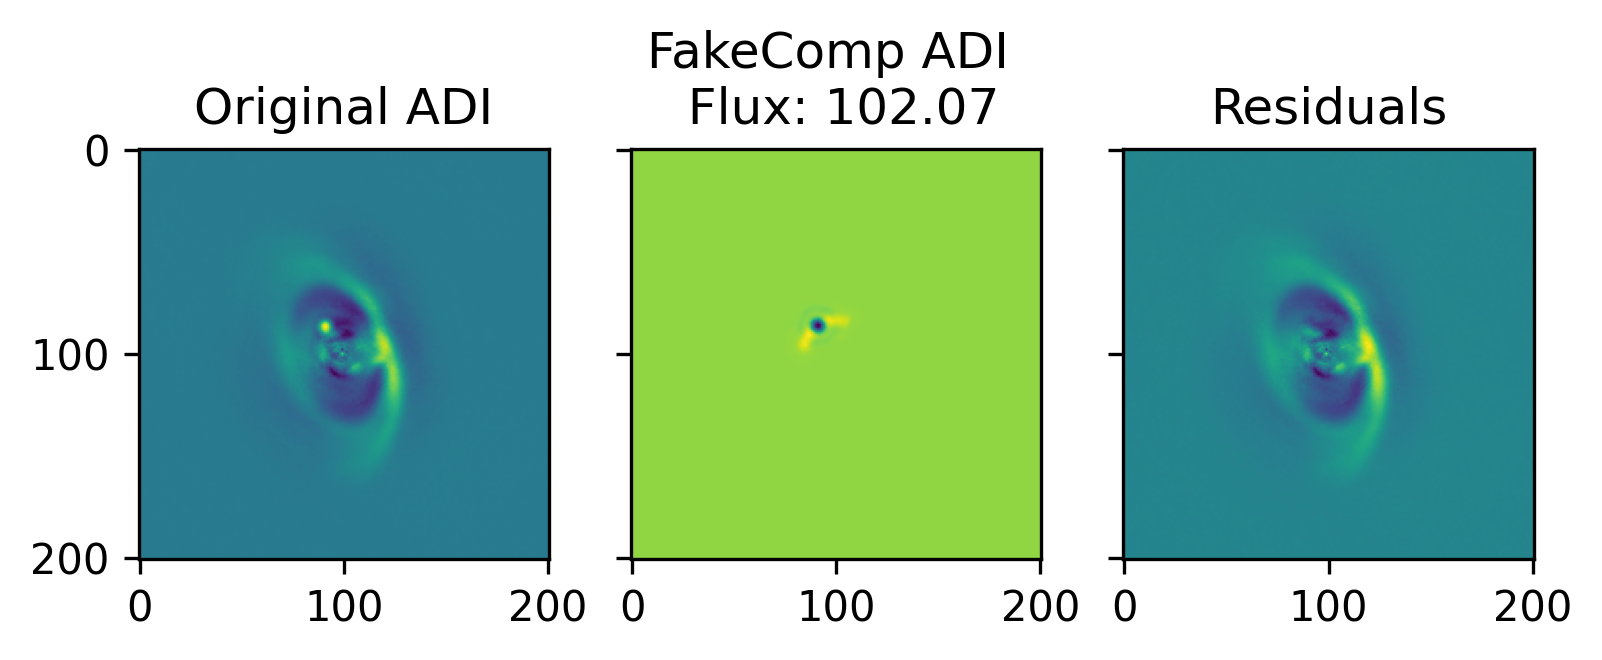

In [63]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(adi_image)
axes[0].set_title('Original ADI')
axes[1].imshow(adi_image_fake_zeros)
axes[1].set_title('FakeComp ADI \n Flux: {:.2f}'.format(flux_firstguess))
axes[2].imshow(adi_image+adi_image_fake_zeros)
axes[2].set_title('Residuals')

# axes[2].set_xlim(x_firstguess-100, x_firstguess+100)
# axes[2].set_ylim(y_firstguess-100, y_firstguess+100)

### MCMC

In [48]:
from gpu.mcmc import run_chain, run_chain_only_flux

In [49]:
# %%time
# init_state = [x_firstguess.numpy()[0], y_firstguess.numpy()[0], flux_firstguess]
# results = run_chain(init_state, fwhm_*2, cube[0], normalized_psf[0], 
#                     rot_ang, num_results=10000)
# titles = ['x', 'y', 'flux']

In [50]:
%%time
init_state = [flux_firstguess]

results = run_chain_only_flux(init_state, 
                              x_firstguess, 
                              y_firstguess, 
                              table.iloc[0]['fwhm_mean']*3, 
                              cube[0], 
                              normalized_psf[0], 
                              rot_ang, 
                              num_results=5000)
titles = ['flux']

/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2023-05-16 16:33:10.564081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/cond_1/branch_executed/_41


CPU times: user 1min 48s, sys: 9.53 s, total: 1min 58s
Wall time: 47.6 s


In [51]:
start = 0
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

tf.Tensor(102.07369, shape=(), dtype=float32)  -  97.322716


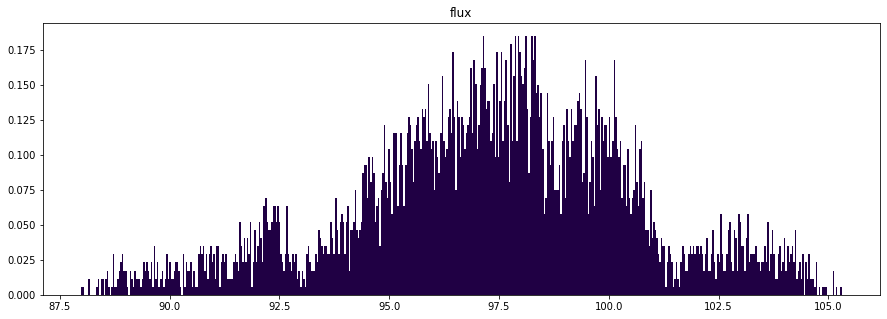

In [53]:
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
    
for i, r in enumerate(samples):
    axes[i].hist(np.ravel(r), bins=500, color='#200044', density=True)
    axes[i].set_title(titles[i])

## Visualizing Results

In [247]:
try:
    x_star = opt_values[0]
    y_star = opt_values[1]
    flux_star = opt_values[2]
except:
    x_star = x_firstguess.numpy()[0]
    y_star = y_firstguess.numpy()[0]
    flux_star = opt_values[0]

In [248]:
x_star, y_star, flux_star

(91.43079, 86.833885, 87.77761)

In [249]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = patch, 
                                rot_angles = rot_ang)

fake_cube_adi = tfnegfc.apply_adi(fake_cube, 
                                  rot_ang, 
                                  out_size=(cube[0].shape),
                                  ncomp=1, 
                                  derotate='tf')

In [ ]:
plt.figure(figsize=(5,5),dpi=200)
plt.imshow(fake_cube_adi)
plt.title('(x, y) = ({:.2f}, {:.2f}) - flux {:.2f}'.format(x_star, y_star, flux_star))
plt.xticks([])
plt.yticks([])
plt.show()